# Ground-truth performance and gradient norms

This notebook inspects the initialization schemes for LQGs and time-varying linear policies described in section 5.1 of the [paper](https://www.overleaf.com/read/cmbgmxxpxqzr).

### Checklist

- [x] Fix `n_state`, `n_ctrl`, `horizon`
- [x] Sample random LQGs
- [x] Sample random policies
- [x] Evaluate the expected return
- [x] Evaluate the value gradient norm
- [ ] Search numpy, scipy for methods for visualizing the distributions

### Imports

In [1]:
%matplotlib inline
from __future__ import annotations

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import lqsvg.torch.named as nt
from lqsvg.envs import lqr
from lqsvg.envs.lqr.gym import LQGSpec
from torch import Tensor

In [2]:
n_state = 2
n_ctrl = 2
horizon = 100

In [3]:
def sample_lqg(n_state: int, n_ctrl: int, horizon: int) -> tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]:
    spec = LQGSpec(
        n_state=n_state,
        n_ctrl=n_ctrl,
        horizon=horizon,
        stationary=False,
        gen_seed=None,
        num_envs=1,  # No effect
    )
    return spec.make_lqg()

In [4]:
def test_sample_lqg():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    assert isinstance(dynamics, lqr.LinSDynamics)
    assert isinstance(cost, lqr.QuadCost)
    assert isinstance(init, lqr.GaussInit)

In [5]:
test_sample_lqg()

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:848.)
  return super(Tensor, self).refine_names(names)


In [6]:
def dims_from_dynamics(dynamics: lqr.LinSDynamics) -> tuple[int, int, int]:
    n_state = dynamics.F.size("R")
    n_ctrl = dynamics.F.size("C") - n_state
    horizon = dynamics.F.size("H")
    return n_state, n_ctrl, horizon

In [7]:
def sample_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    solver = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    pistar, _, _ = solver(dynamics, cost)
    
    K, k = (g + torch.randn_like(g) / (n_state + n_ctrl + horizon) for g in pistar)
    return (K, k)

In [8]:
def test_sample_policy():
    dynamics, cost, _ = sample_lqg(n_state, n_ctrl, horizon)
    K, k = sample_policy(dynamics, cost)
    print(f"""
        K: {K.shape}; {K.names}
        k: {k.shape}; {k.names}
    """)

In [9]:
test_sample_policy()


        K: torch.Size([100, 2, 2]); ('H', 'R', 'C')
        k: torch.Size([100, 2]); ('H', 'R')
    


In [10]:
class ExpectedValue(nn.Module):
    def forward(self, init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
        """Expected cost given mean and covariance matrix of the initial state.

        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        V, v, c = vval
        V = nt.matrix(V)
        v = nt.vector_to_matrix(v)
        c = nt.scalar_to_matrix(c)
        mu = nt.vector_to_matrix(init.mu)
        sig = nt.matrix(init.sig)

        value = (
            nt.scalar_to_matrix(nt.trace(sig @ V)) / 2
            + nt.transpose(mu) @ V @ mu
            + nt.transpose(v) @ mu
            + c
        )
        return nt.matrix_to_scalar(value)


class PolicyLoss(nn.Module):
    def __init__(self, n_state: int, n_ctrl: int, horizon: int):
        super().__init__()
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.expected = ExpectedValue()

    def forward(
        self,
        policy: lqr.Linear,
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ) -> Tensor:
        _, vval = self.predict(policy, dynamics, cost)
        vval = tuple(x.select("H", 0) for x in vval)
        cost = self.expected(init, vval)
        return cost

In [11]:
def policy_loss(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> Tensor:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    loss_fn = PolicyLoss(n_state, n_ctrl, horizon)
    loss = loss_fn(policy, dynamics, cost, init)
    return loss

In [12]:
def test_policy_loss():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    policy = sample_policy(dynamics, cost)
    loss = policy_loss(policy, dynamics, cost, init)
    print(f"Loss: {loss} ({loss.dtype}); ExpectedReturn: {-loss} ({(-loss).dtype})")

In [13]:
test_policy_loss()

Loss: 333.1877136230469 (torch.float32); ExpectedReturn: -333.1877136230469 (torch.float32)


In [14]:
def test_value_gradient_norm():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    policy = tuple(x.requires_grad_(True) for x in sample_policy(dynamics, cost))
    eret = -policy_loss(policy, dynamics, cost, init)
    print(f"Expected return: {eret} ({eret.dtype})")
    eret.backward()
    svg_norm = nn.utils.clip_grad_norm_(policy, max_norm=float("inf"))
    print(f"SVG norm: {svg_norm} ({svg_norm.dtype})")

In [15]:
test_value_gradient_norm()

Expected return: -175.96194458007812 (torch.float32)
SVG norm: 12.998212814331055 (torch.float32)


In [16]:
def get_optimal(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> tuple[lqr.Linear, lqr.Quadratic, lqr.Quadratic]:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    solver = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    pistar, qstar, vstar = solver(dynamics, cost)
    return pistar, qstar, vstar

In [17]:
def test_optimal():
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon)
    pistar, _, vstar = get_optimal(dynamics, cost)
    loss_fn = ExpectedValue()
    eret = -loss_fn(init, tuple(x.select("H", 0) for x in vstar))
    print(f"Optimal expected return: {eret} ({eret.dtype})")

    policy = tuple(x.requires_grad_(True) for x in pistar)
    eret = -policy_loss(policy, dynamics, cost, init)
    print(f"Expected return: {eret} ({eret.dtype})")
    eret.backward()
    svg_norm = nn.utils.clip_grad_norm_(policy, max_norm=float("inf"))
    print(f"SVG norm: {svg_norm} ({svg_norm.dtype})")

In [18]:
test_optimal()

Optimal expected return: -234.11837768554688 (torch.float32)
Expected return: -234.11837768554688 (torch.float32)
SVG norm: 0.00013003389176446944 (torch.float32)


## Evaluate cost scaling

### Checklist
- [x] Stack several LQGs including init dists
- [x] Define range of `n_state`s, `n_ctrl`s, and `horizon`s
- [x] Fix initial values of `n_state=2`, `n_ctrl=2`, `horizon=100`
- [ ] Iterate over one of the ranges, e.g., `horizon`s:
  - [ ] Generate several LQGs with the current `n_state`, `n_ctrl`, `horizon` and stack them
  - [ ] Find the optimal solutions (policies) and evaluate the optimal expected returns
  - [ ] Average the results accross the LQGs generated
  - [ ] Plot the average against the current `n_state`, `n_ctrl`, `horizon`

In [19]:
def stack_lqgs(*lqgs: tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]) -> tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]:
    separated: tuple[list[lqr.LinSDynamics], list[lqr.QuadCost], list[lqr.GaussInit]] = zip(*lqgs)
    dyns, costs, inits = separated

    def stack_batch(tensors: list[Tensor]) -> Tensor:
        return torch.cat([t.align_to("H", "B", ...) for t in tensors], dim="B")

    Fs, fs, Ws = zip(*dyns)
    dynamics = lqr.LinSDynamics(F=stack_batch(Fs), f=stack_batch(fs), W=stack_batch(Ws))

    Cs, cs = zip(*costs)
    cost = lqr.QuadCost(C=stack_batch(Cs), c=stack_batch(cs))
    
    mus, sigs = zip(*inits)
    init = lqr.GaussInit(mu=stack_batch(mus).squeeze("H"), sig=stack_batch(sigs).squeeze("H"))

    return dynamics, cost, init

In [20]:
def test_stack_lqgs():
    lqgs = [sample_lqg(n_state, n_ctrl, horizon) for _ in range(10)]
    dynamics, cost, init = stack_lqgs(*lqgs)
    print(f"""
        dynamics: 
            {dynamics.F.shape}; {dynamics.F.names}
            {dynamics.f.shape}; {dynamics.f.names}
            {dynamics.W.shape}; {dynamics.W.names}
            
        cost:
            {cost.C.shape}; {cost.C.names}
            {cost.c.shape}; {cost.c.names}
            
        init:
            {init.mu.shape}; {init.mu.names}
            {init.sig.shape}; {init.sig.names}
    """)

In [21]:
test_stack_lqgs()


        dynamics: 
            torch.Size([100, 10, 2, 4]); ('H', 'B', 'R', 'C')
            torch.Size([100, 10, 2]); ('H', 'B', 'R')
            torch.Size([100, 10, 2, 2]); ('H', 'B', 'R', 'C')
            
        cost:
            torch.Size([100, 10, 4, 4]); ('H', 'B', 'R', 'C')
            torch.Size([100, 10, 4]); ('H', 'B', 'R')
            
        init:
            torch.Size([10, 2]); ('B', 'R')
            torch.Size([10, 2, 2]); ('B', 'R', 'C')
    


In [22]:
ctrl_dims = range(1, 10)
horizons = range(10, 1000)

In [23]:
n_state, n_ctrl, horizon = 2, 2, 100

In [24]:
def expected_return(init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
    expected_value = ExpectedValue()
    expected_cost = expected_value(init, tuple(x.select("H", 0) for x in vval))
    return -expected_cost

In [25]:
def list_rets_by_lqg_dim(lqg_dims: list[tuple[int, int, int]], sample_size: int = 100) -> list[Tensor]:
    rets = []
    for n_state, n_ctrl, horizon in lqg_dims:
        lqgs = [sample_lqg(n_state, n_ctrl, horizon) for _ in range(sample_size)]
        dynamics, cost, init = stack_lqgs(*lqgs)
        pistar, qstar, vstar = get_optimal(dynamics, cost)
        eret = expected_return(init, vstar)
#         print(f"""
#             state dim: {n_state}, ctrl_dim: {n_ctrl}, horizon: {horizon}
#             expected return: mean - {eret.mean()} - std {eret.std()} - min {eret.min()} - max {eret.max()}
#         """)
        rets += [eret]
        
    return rets

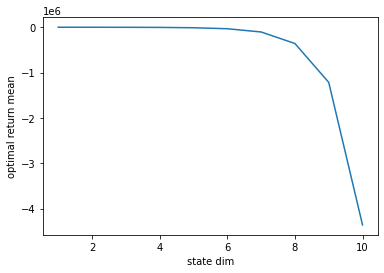

In [35]:
state_dims = range(1, 11)
ctrl_dims = [2] * 10
horizons = [100] * 10
rets = list_rets_by_lqg_dim(list(zip(state_dims, ctrl_dims, horizons)))

x = "state dim"; y = "optimal return mean"
data={x: state_dims, y: [r.mean().item() for r in rets]}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

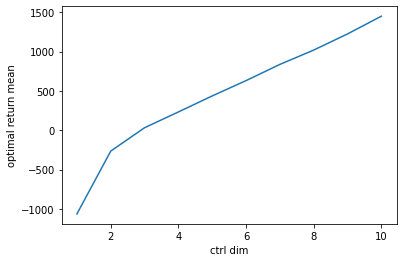

In [32]:
state_dims = [2] * 10
ctrl_dims = range(1, 11)
horizons = [100] * 10
rets = list_rets_by_lqg_dim(list(zip(state_dims, ctrl_dims, horizons)))

x = "ctrl dim"; y = "optimal return mean"
data = {x: ctrl_dims, y: [r.mean().item() for r in rets]}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

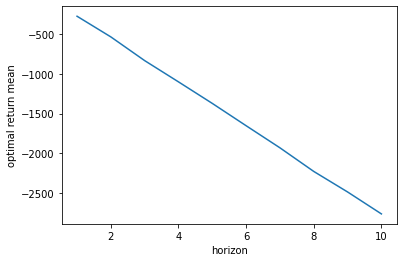

In [34]:
state_dims = [2] * 10
ctrl_dims = [2] * 10
horizons = [100 * i for i in range(1, 11)]
rets = list_rets_by_lqg_dim(list(zip(state_dims, ctrl_dims, horizons)))

x = "horizon"; y = "optimal return mean"
data = {x: horizons, y: [r.mean().item() for r in rets]}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

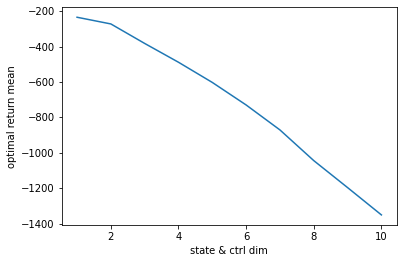

In [37]:
state_dims = range(1, 11)
ctrl_dims = state_dims
horizons = [100] * 10
rets = list_rets_by_lqg_dim(list(zip(state_dims, ctrl_dims, horizons)))

x = "state & ctrl dim"; y = "optimal return mean"
data = {x: state_dims, y: [r.mean().item() for r in rets]}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()